In [1]:
import pandas as pd

df = pd.read_csv("resultados_globais.csv")

df.head()

,Modelo,Acurácia Teste,Tempo Treinamento (s),Melhores Parâmetros
0,LogisticRegression | Balanceamento: Nenhum | P...,0.653123,0.892039,NaN
1,RandomForest | Balanceamento: Nenhum | PCA: Nã...,0.601577,3.614778,NaN
2,SVM | Balanceamento: Nenhum | PCA: Não | Param...,0.642207,17.994667,NaN
3,KNN | Balanceamento: Nenhum | PCA: Não | Param...,0.593087,0.007397,NaN
4,DecisionTree | Balanceamento: Nenhum | PCA: Nã...,0.584597,0.429140,NaN


## Extrair partes do nome do modelo

In [2]:

df["ModeloBase"] = df["Modelo"].str.split("|").str[0].str.strip()
df["Balanceamento"] = df["Modelo"].str.extract(r"Balanceamento: (\w+)")[0]
df["PCA"] = df["Modelo"].str.extract(r"PCA: (\w+)")[0]
df["tipo_parametros"] = df["Modelo"].str.extract(r"Parametros: (\w+)")[0]

df.head()

,Modelo,Acurácia Teste,Tempo Treinamento (s),Melhores Parâmetros,ModeloBase,Balanceamento,PCA,tipo_parametros
0,LogisticRegression | Balanceamento: Nenhum | P...,0.653123,0.892039,NaN,LogisticRegression,Nenhum,Não,default
1,RandomForest | Balanceamento: Nenhum | PCA: Nã...,0.601577,3.614778,NaN,RandomForest,Nenhum,Não,default
2,SVM | Balanceamento: Nenhum | PCA: Não | Param...,0.642207,17.994667,NaN,SVM,Nenhum,Não,default
3,KNN | Balanceamento: Nenhum | PCA: Não | Param...,0.593087,0.007397,NaN,KNN,Nenhum,Não,default
4,DecisionTree | Balanceamento: Nenhum | PCA: Nã...,0.584597,0.429140,NaN,DecisionTree,Nenhum,Não,default


In [3]:
# Pega o índice da linha com a maior acurácia
indice_max = df['Acurácia Teste'].idxmax()

# Usa .loc para selecionar a linha inteira por esse índice
df.loc[indice_max]

Modelo                   LogisticRegression | Balanceamento: Nenhum | P...
Acurácia Teste                                                    0.653123
Tempo Treinamento (s)                                             0.892039
Melhores Parâmetros                                                    NaN
ModeloBase                                              LogisticRegression
Balanceamento                                                       Nenhum
PCA                                                                    Não
tipo_parametros                                                    default
Name: 0, dtype: object

In [4]:
# Extrair tipo de parâmetro
df["TipoParametro"] = df["Modelo"].str.extract(r"(default|grid|best)")[0]

# Ajustar balanceamento (caso não tenha, é "none")
df["Balanceamento"] = df["Modelo"].str.extract(r"Balanceamento: (\w+)")[0].fillna("none")

# Ajustar PCA (caso não tenha, é False)
df["PCA"] = df["Modelo"].str.extract(r"PCA: (\w+)")[0].fillna("False")

# Criar a coluna de cenário padronizada
df["Cenário"] = (
    df["TipoParametro"].str.capitalize() +
    " | Balanceamento: " + df["Balanceamento"].str.upper() +
    " | PCA: " + df["PCA"]
)


In [5]:
tabela_melhores = df.pivot_table(
    index="Cenário",
    columns="ModeloBase",
    values="Acurácia Teste",
    aggfunc="max"
).reset_index()

# Tabela de menor tempo de treino (ou use 'mean' se preferir)
tabela_tempos = df.pivot_table(
    index="Cenário",
    columns="ModeloBase",
    values="Tempo Treinamento (s)",
    aggfunc="min"
).reset_index()

# Renomear colunas para diferenciar
tabela_tempos = tabela_tempos.add_suffix(" (Tempo)").rename(columns={"Cenário (Tempo)": "Cenário"})

# Juntar as duas tabelas pelo cenário
tabela_completa = pd.merge(tabela_melhores, tabela_tempos, on="Cenário", how="left")

# Exemplo de formatação para exibição
tabela_formatada = tabela_completa.copy()
for col in tabela_formatada.columns[1:]:
    if "Acurácia" in col:
        tabela_formatada[col] = tabela_formatada[col].apply(lambda x: f"{x*100:.2f}%" if pd.notna(x) else '')
    elif "Tempo" in col:
        tabela_formatada[col] = tabela_formatada[col].apply(lambda x: f"{x:.2f}s" if pd.notna(x) else '')

print(tabela_formatada)


ModeloBase                                     Cenário  DecisionTree  \
0           Default | Balanceamento: NENHUM | PCA: Não      0.584597   
1            Default | Balanceamento: SMOTE | PCA: Não      0.584597   
2            Default | Balanceamento: SMOTE | PCA: Sim      0.536689   
3            Default | Balanceamento: TOMEK | PCA: Não      0.584597   
4            Default | Balanceamento: TOMEK | PCA: Sim      0.546392   
5              Grid | Balanceamento: NENHUM | PCA: Não      0.599757   
6               Grid | Balanceamento: SMOTE | PCA: Não      0.599151   
7               Grid | Balanceamento: SMOTE | PCA: Sim      0.588235   
8               Grid | Balanceamento: TOMEK | PCA: Não      0.599757   
9               Grid | Balanceamento: TOMEK | PCA: Sim      0.588842   

ModeloBase       KNN  LogisticRegression  NaiveBayes  NeuralNetwork  \
0           0.593087            0.653123    0.338993       0.628260   
1           0.593087            0.653123    0.338993       0.6270

In [6]:
melhores_resultados = pd.DataFrame(tabela_formatada)
melhores_resultados

ModeloBase,Cenário,DecisionTree,KNN,LogisticRegression,NaiveBayes,NeuralNetwork,RandomForest,SVM,DecisionTree (Tempo),KNN (Tempo),LogisticRegression (Tempo),NaiveBayes (Tempo),NeuralNetwork (Tempo),RandomForest (Tempo),SVM (Tempo)
0,Default | Balanceamento: NENHUM | PCA: Não,0.584597,0.593087,0.653123,0.338993,0.628260,0.601577,0.642207,0.43s,0.01s,0.89s,0.05s,19.67s,3.61s,17.99s
1,Default | Balanceamento: SMOTE | PCA: Não,0.584597,0.593087,0.653123,0.338993,0.627047,0.611886,0.642207,0.48s,0.01s,0.95s,0.06s,17.94s,3.75s,17.08s
2,Default | Balanceamento: SMOTE | PCA: Sim,0.536689,0.588235,0.629472,0.557307,0.626440,0.622802,0.628866,1.08s,0.01s,0.14s,0.01s,4.79s,7.37s,1.83s
3,Default | Balanceamento: TOMEK | PCA: Não,0.584597,0.593087,0.653123,0.338993,0.617344,0.607641,0.642207,0.52s,0.01s,0.97s,0.07s,19.68s,4.09s,17.61s
4,Default | Balanceamento: TOMEK | PCA: Sim,0.546392,0.590661,0.625834,0.541540,0.628260,0.617950,0.628260,1.08s,0.01s,0.11s,0.01s,4.68s,7.15s,1.82s
5,Grid | Balanceamento: NENHUM | PCA: Não,0.599757,0.596725,0.651304,0.338993,0.647665,0.624015,0.642814,1.15s,6.59s,8.36s,0.06s,41.70s,23.34s,128.67s
6,Grid | Balanceamento: SMOTE | PCA: Não,0.599151,0.596725,0.651304,0.338993,0.642207,0.624621,0.642814,1.04s,6.51s,5.64s,0.05s,55.33s,24.80s,147.08s
7,Grid | Balanceamento: SMOTE | PCA: Sim,0.588235,0.614312,0.627047,0.541540,0.650697,0.631898,0.627047,1.90s,0.75s,1.76s,0.01s,9.90s,31.25s,5.91s
8,Grid | Balanceamento: TOMEK | PCA: Não,0.599757,0.596725,0.651304,0.338993,0.648272,0.623408,0.642814,0.99s,6.61s,7.42s,0.05s,51.41s,18.47s,171.58s
9,Grid | Balanceamento: TOMEK | PCA: Sim,0.588842,0.610673,0.624621,0.542753,0.636143,0.637962,0.626440,1.95s,0.81s,1.62s,0.01s,9.83s,36.82s,7.87s


In [7]:
# Agora pegar o melhor de cada cenário por modelo
melhores_por_modelo_cenario = df.loc[
    df.groupby(["ModeloBase", "Cenário"])["Acurácia Teste"].idxmax()
]

import pandas as pd
pd.set_option("display.max_rows", None)  # Para não truncar

melhores_por_modelo_cenario = melhores_por_modelo_cenario[
    ["ModeloBase", "Cenário", "Acurácia Teste", "Melhores Parâmetros"]
]

In [8]:
# Ordenar por ModeloBase e Acurácia Teste decrescente
df_ranking = melhores_por_modelo_cenario.copy()
df_ranking = df_ranking.sort_values(by=["ModeloBase", "Acurácia Teste"], ascending=[True, False])

# Criar a coluna de ranking dentro de cada modelo
df_ranking["Rank"] = df_ranking.groupby("ModeloBase")["Acurácia Teste"].rank(method="first", ascending=False)

# Ordenar para visualização final (opcional)
df_ranking = df_ranking.sort_values(by=["Rank", "ModeloBase"])

df_ranking


,ModeloBase,Cenário,Acurácia Teste,Melhores Parâmetros,Rank
39,DecisionTree,Grid | Balanceamento: NENHUM | PCA: Não,0.599757,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",1.0
59,KNN,Grid | Balanceamento: SMOTE | PCA: Sim,0.614312,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",1.0
0,LogisticRegression,Default | Balanceamento: NENHUM | PCA: Não,0.653123,NaN,1.0
27,NaiveBayes,Default | Balanceamento: SMOTE | PCA: Sim,0.557307,NaN,1.0
61,NeuralNetwork,Grid | Balanceamento: SMOTE | PCA: Sim,0.650697,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",1.0
64,RandomForest,Grid | Balanceamento: TOMEK | PCA: Sim,0.637962,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",1.0
37,SVM,Grid | Balanceamento: NENHUM | PCA: Não,0.642814,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",1.0
53,DecisionTree,Grid | Balanceamento: TOMEK | PCA: Não,0.599757,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",2.0
66,KNN,Grid | Balanceamento: TOMEK | PCA: Sim,0.610673,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",2.0
7,LogisticRegression,Default | Balanceamento: SMOTE | PCA: Não,0.653123,NaN,2.0


In [9]:
melhor_global = melhores_por_modelo_cenario.loc[
    melhores_por_modelo_cenario["Acurácia Teste"].idxmax()
]

melhor_global

ModeloBase                                     LogisticRegression
Cenário                Default | Balanceamento: NENHUM | PCA: Não
Acurácia Teste                                           0.653123
Melhores Parâmetros                                           NaN
Name: 0, dtype: object

                Modelo                                     Cenário  \
39        DecisionTree     Grid | Balanceamento: NENHUM | PCA: Não   
59                 KNN      Grid | Balanceamento: SMOTE | PCA: Sim   
0   LogisticRegression  Default | Balanceamento: NENHUM | PCA: Não   
27          NaiveBayes   Default | Balanceamento: SMOTE | PCA: Sim   
61       NeuralNetwork      Grid | Balanceamento: SMOTE | PCA: Sim   
64        RandomForest      Grid | Balanceamento: TOMEK | PCA: Sim   
37                 SVM     Grid | Balanceamento: NENHUM | PCA: Não   

    Acurácia Teste  Tempo Treinamento (s)  
39        0.599757               1.151198  
59        0.614312               0.745148  
0         0.653123               0.892039  
27        0.557307               0.009990  
61        0.650697               9.898204  
64        0.637962              36.817311  
37        0.642814             128.668786  


/tmp/ipykernel_2924544/3431797183.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=melhores_resultados, x='Modelo', y='Acurácia Teste', palette='viridis', ax=ax1, legend=False)


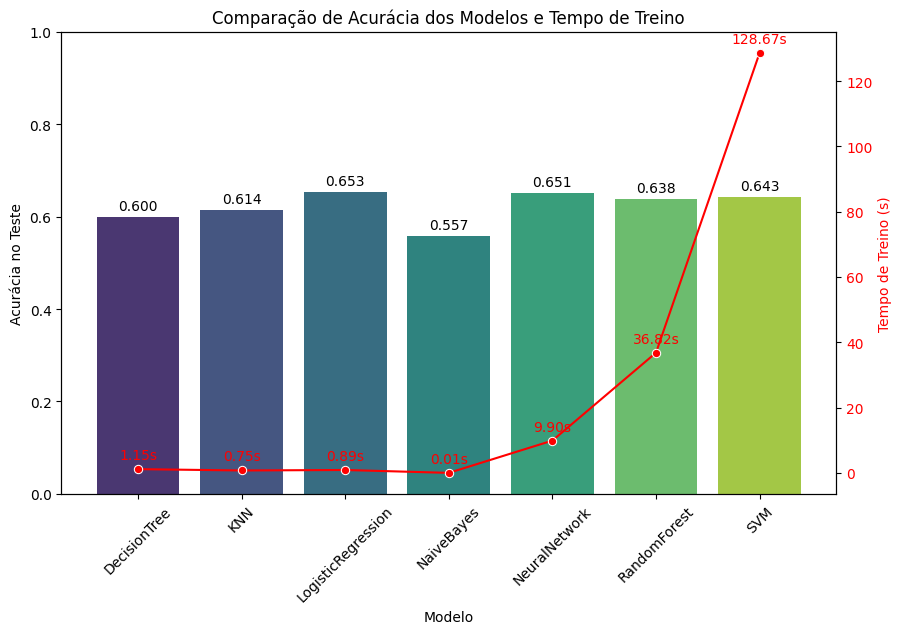

In [10]:
# Pegue o melhor resultado de cada modelo (incluindo o cenário)
melhores_resultados = df.loc[
    df.groupby('ModeloBase')['Acurácia Teste'].idxmax(),
    ['ModeloBase', 'Cenário', 'Acurácia Teste', 'Tempo Treinamento (s)']
].rename(columns={'ModeloBase': 'Modelo'})

print(melhores_resultados)

# Gráfico (opcional, igual ao anterior)
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

sns.barplot(data=melhores_resultados, x='Modelo', y='Acurácia Teste', palette='viridis', ax=ax1, legend=False)
ax1.set_ylabel('Acurácia no Teste')
ax1.set_xlabel('Modelo')
ax1.set_ylim(0, 1)
ax1.set_title('Comparação de Acurácia dos Modelos e Tempo de Treino')
ax1.tick_params(axis='x', rotation=45)

for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.3f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                 textcoords='offset points')

ax2 = ax1.twinx()
sns.lineplot(data=melhores_resultados, x='Modelo', y='Tempo Treinamento (s)', marker='o', color='red', ax=ax2)
ax2.set_ylabel('Tempo de Treino (s)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for x, y in zip(melhores_resultados['Modelo'], melhores_resultados['Tempo Treinamento (s)']):
    ax2.annotate(f'{y:.2f}s', (x, y), color='red', fontsize=10, ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.show()
